## Objective
Objective is to build a predictive model that predicts the cost of health insurance based on the customer's demography and habits.

In this excercise, we will try out multiple regression algorithm and see which one gives the best result.
  - Linear Regression
  - Decission Tree
  - Random Forest
  - Ada Boost
  - Gradient Boost
  - XGBoost

| Model           | Type          | Strengths 🚀                 | Weaknesses ⚠️        | Best For                  |
|-----------------|---------------|------------------------------|----------------------|---------------------------|
| Decision Tree   | Single Tree   | Simple, interpretable        | Overfits easily      | Small/simple problems     |
| Random Forest   | Bagging       | Reduces overfitting, robust  | Less interpretable, slower | Default strong baseline   |
| AdaBoost        | Boosting      | Improves weak learners       | Sensitive to noise   | Medium datasets           |
| Gradient Boost  | Boosting      | Very accurate                | Slower, complex tuning | Accuracy-focused tasks   |
| XGBoost         | Optimized GB  | Fast, regularized, state-of-art | Complex tuning    | Large datasets, Kaggle    |


Reference:
https://www.kaggle.com/code/ahmetemirdundar/medical-cost-prediction/notebook

In [63]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EDA

In [64]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [65]:
# Load Data
df = pd.read_csv('/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [67]:
# Basic Stastical Analysis
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


**Insight - 1**
- sex, smoker, and region are categorical features
- age, bmi, children, and charges are numerical features.
- No null or missing value present.
- Age IQR (75% - 25%) is 24
- Age Relative IQR (IQR/median(50%)) = 24/39 = 0.6153 = 61.53%. It means age has high variation or spread. **_Random Forest and XGBoost handles variaations better._**
- Mean and Median of  Age ~39. Suggesting minimal or no skew.

- BMI IQR (75% - 25%) is  8.3975
- BMI Relative IQR (IQR/Median) = 8.3975/30.40 = .27 = 27%. Moderate variation.
- Mean and Median of BMI ~30. Suggesting mininal or no skew.

- Age Min-Max range is 48m, bmi range is 38, and charges range is 51000. It mean, we must apply scaling.

In [68]:
# Verify the skewness
import pandas as pd
print(df[['age', 'bmi', 'charges']].skew())


# **Skewness Interpretation:**
# ```
# -   ≈ 0 → fairly symmetric
# -   > 0.5 → moderate right skew
# -   > 1 → strong right skew
# -   < -0.5 → moderate left skew
# -   < -1 → strong left skew
# ```

age        0.055673
bmi        0.284047
charges    1.515880
dtype: float64


In [69]:
# Verify outliers
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers

age_outliers = detect_outliers_iqr(df['age'])
bmi_outliers = detect_outliers_iqr(df['bmi'])
charges_outliers = detect_outliers_iqr(df['charges'])

print(f"Age outliers count: {len(age_outliers)}")
print(f"Salary outliers count: {len(bmi_outliers)}")
print(f"Charges outliers count: {len(charges_outliers)}")

# Interpretation:
# If the count of outliers is significant, it may indicate that the data has extreme values
# that could affect the model's performance. Further investigation is needed to determine
# whether to remove or treat these outliers.


Age outliers count: 0
Salary outliers count: 9
Charges outliers count: 139


**Insight - 2**
- target feature (charges) has high skewness, and has multiple outliers. Hence, the feature must be scaled using logarithim scaling.


#### Peform Categorical Analysis

In [70]:
print(df['sex'].value_counts(normalize=True) * 100)
print(df['smoker'].value_counts(normalize=True) * 100)
print(df['region'].value_counts(normalize=True) * 100)

sex
male      50.523169
female    49.476831
Name: proportion, dtype: float64
smoker
no     79.521674
yes    20.478326
Name: proportion, dtype: float64
region
southeast    27.204783
southwest    24.289985
northwest    24.289985
northeast    24.215247
Name: proportion, dtype: float64


**Insight - 3**
- sex and region classes seems equally distributed.
- feature smoker look imbalanced in the dataset. Hence, Consider using stratified sampling when splitting train/test.

## Understand the Regression Evaluation Metrics

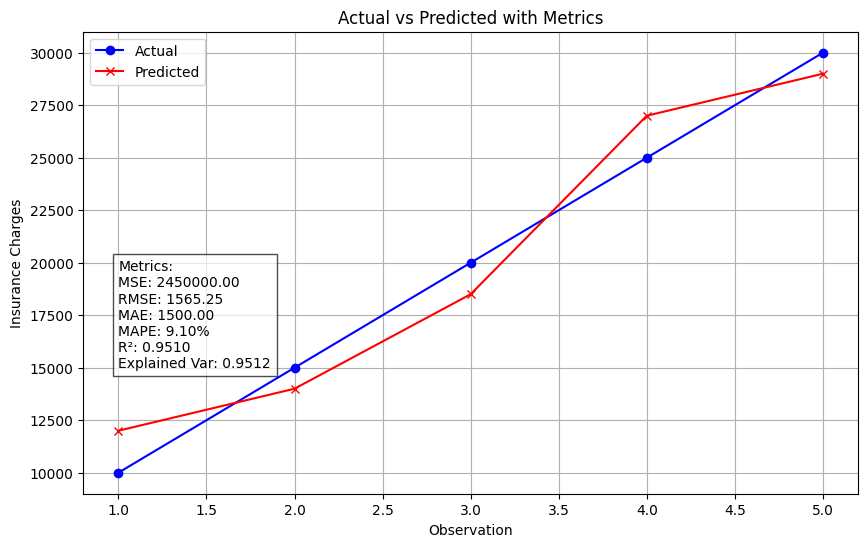

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
obs = np.arange(1, 6)
y_actual = np.array([10000, 15000, 20000, 25000, 30000])
y_pred = np.array([12000, 14000, 18500, 27000, 29000])

# Calculate metrics
mse = np.mean((y_actual - y_pred)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_actual - y_pred))
mape = np.mean(np.abs(y_actual - y_pred)/y_actual)
r2 = 1 - np.sum((y_actual - y_pred)**2)/np.sum((y_actual - np.mean(y_actual))**2)
expl_var = 1 - np.var(y_actual - y_pred)/np.var(y_actual)

# Plot Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(obs, y_actual, marker='o', label='Actual', color='blue')
plt.plot(obs, y_pred, marker='x', label='Predicted', color='red')
plt.title("Actual vs Predicted with Metrics")
plt.xlabel("Observation")
plt.ylabel("Insurance Charges")
plt.grid(True)

# Annotate metrics on the plot
metrics_text = f"""Metrics:
MSE: {mse:.2f}
RMSE: {rmse:.2f}
MAE: {mae:.2f}
MAPE: {mape*100:.2f}%
R²: {r2:.4f}
Explained Var: {expl_var:.4f}"""

plt.text(1, max(y_actual)*0.5, metrics_text, bbox=dict(facecolor='white', alpha=0.7))

plt.legend()
plt.show()


# residuals = [a - p for a, p in zip(y_actual, y_pred)]
# plt.bar(obs, residuals)
# plt.axhline(0, color='black', linestyle='--')
# plt.title("Residuals (Actual - Predicted)")
# plt.xlabel("Observation")
# plt.ylabel("Residual")
# plt.show()



#### Understanding R² and Regression Metrics

This document explains the key regression metrics used to evaluate model performance, with a focus on **R² (R-squared)**, and how to interpret them both numerically and visually.

---

##### 1. Regression Metrics

###### **1.1 Mean Squared Error (MSE)**

- **Definition:** Average of the squared differences between actual and predicted values.
$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$
- **Interpretation:** Penalizes large errors heavily. Lower is better.  
- **Unit:** Squared unit of the target variable.

---

###### **1.2 Root Mean Squared Error (RMSE)**

- **Definition:** Square root of MSE.
$
\text{RMSE} = \sqrt{\text{MSE}}
$
- **Interpretation:** Gives error in the same units as the target. Lower is better.

---

###### **1.3 Mean Absolute Error (MAE)**

- **Definition:** Average of absolute differences between actual and predicted values.
$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$
- **Interpretation:** Less sensitive to outliers than MSE/RMSE. Lower is better.

---

###### **1.4 Mean Absolute Percentage Error (MAPE)**

- **Definition:** Average absolute error as a percentage of actual values.
$
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{|y_i|}
$
- **Interpretation:** Shows relative error. Lower percentage is better. Sensitive to very small actual values.

---

###### **1.5 Explained Variance**

- **Definition:** Fraction of variance captured by the model compared to total variance.
$
\text{Explained Variance} = 1 - \frac{\text{Var}(y - \hat{y})}{\text{Var}(y)}
$
- **Interpretation:** Value close to 1 means most variance is explained.

---

##### 2. R-Squared (R²)

###### **2.1 Definition**

$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$

Where:  
- $y_i$ = actual values  
- $\hat{y}_i$ = predicted values  
- $\bar{y}$ = mean of actual values  

**Meaning:** Measures the proportion of variance in the target variable explained by the model.

---

###### **2.2 Interpretation**

| R² Value      | Interpretation                                  |
|---------------|-----------------------------------------------|
| 1             | Perfect fit, 100% variance explained          |
| 0             | Model does no better than predicting the mean |
| < 0           | Model is worse than predicting the mean       |
| 0.7 - 1.0     | Strong model, explains most variance          |
| 0.4 - 0.7     | Moderate model performance                     |
| < 0.4         | Poor model performance                         |

---

###### **2.3 Example**

| Observation | Actual (y) | Predicted (ŷ) |
|------------|------------|---------------|
| 1          | 10,000     | 12,000        |
| 2          | 15,000     | 14,000        |
| 3          | 20,000     | 18,500        |
| 4          | 25,000     | 27,000        |
| 5          | 30,000     | 29,000        |

- Mean of actual values: $\bar{y} = 20,000$  
- Total variance: $SS_{tot} = 250,000,000$
- Residual variance: $SS_{res} = 19,000,000$
- R²: $1 - \frac{19,000,000}{250,000,000} \approx 0.924$

**Interpretation:** The model explains **92.4% of the variance** in the target variable.

---

##### 3. Visual Interpretation

- **Line Graph:** Plot **actual vs predicted** values.  
- **Residuals:** Plot actual − predicted values to see error distribution.  

**What to look for:**
- Predicted line close to actual → good performance  
- Residuals scattered around 0 → unbiased model  
- Metrics annotated on graph provide a quick numeric summary.

---

##### 4. Quick Checklist to Evaluate Model

1. **Line graph:** Predicted values track actual values.  
2. **Residuals:** Mostly near 0, no pattern.  
3. **R²:** High (>0.7) → model explains most variance.  
4. **RMSE & MAE:** Low relative to scale of target.  
5. **MAPE:** Low %, ideally <10-15% for good predictions.  

---

✅ **Tip:** For skewed data (like insurance costs), applying a **log transformation** often improves RMSE, MAE, and R².


## Preprocessing

In [72]:
# Here you handle the missing data (that should not be part of the model pipeline)

# Here you handle the outliers (that should not be part of the model pipeline)

## Modular Model Pipeline

In [73]:
"""
Modular Pipeline for Insurance Cost Prediction
----------------------------------------------

This script defines reusable functions to:
1. Create preprocessing pipelines.
2. Build a full ML pipeline with any regressor.
3. Train, predict, and evaluate the model.
"""

# -----------------------------
# Imports
# -----------------------------
import numpy as np
import pandas as pd

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder,
    FunctionTransformer,
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    explained_variance_score
)

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor
)

# 1️⃣ Initialize a list to store results
results = []

# -----------------------------
# Functions
# -----------------------------

def create_preprocessor(X):
    """
    Create a ColumnTransformer for numerical and categorical preprocessing.
    """
    numerical_features = X.select_dtypes(exclude=["object", "category"]).columns
    categorical_features = X.select_dtypes(include=["object", "category"]).columns

    # Numerical pipeline
    num_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("log", FunctionTransformer(np.log1p, validate=True)),
        ("scaler", StandardScaler()),
    ])

    # Categorical pipeline
    cat_transformer = Pipeline([
        # ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ("label_encoder", OrdinalEncoder()),
    ])

    # Combine into a ColumnTransformer
    preprocessor = ColumnTransformer([
        ("num", num_transformer, numerical_features),
        ("cat", cat_transformer, categorical_features)
    ])

    return preprocessor

def build_pipeline(preprocessor, regressor):
    """
    Build a full ML pipeline with preprocessing and the specified regressor.
    """
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", regressor)
    ])
    print_full_pipeline(pipeline)
    return pipeline

def train_evaluate_model(X_train, X_test, y_train, y_test, pipeline):
    """
    Train the pipeline, predict on test data, and evaluate regression metrics.
    Returns predictions and metrics dictionary.
    """
    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_train_pred = pipeline.predict(X_train) #Evaluate on known data/train data
    y_test_pred = pipeline.predict(X_test) #Evaluate on unknown data/test data

    # Evaluation
    metrics_train = {
        "Mean Squared Error": mean_squared_error(y_train, y_train_pred),
        "Root Mean Squared Error": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Mean Absolute Error": mean_absolute_error(y_train, y_train_pred),
        "Mean Absolute Percentage Error": mean_absolute_percentage_error(y_train, y_train_pred),
        "R-Squared": r2_score(y_train, y_train_pred),
        "Explained Variance": explained_variance_score(y_train, y_train_pred)
    }

    metrics_test = {
        "Mean Squared Error": mean_squared_error(y_test, y_test_pred),
        "Root Mean Squared Error": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "Mean Absolute Error": mean_absolute_error(y_test, y_test_pred),
        "Mean Absolute Percentage Error": mean_absolute_percentage_error(y_test, y_test_pred),
        "R-Squared": r2_score(y_test, y_test_pred),
        "Explained Variance": explained_variance_score(y_test, y_test_pred)
    }

    return y_test_pred, metrics_train, metrics_test

def print_metrics(metrics_train, metrics_test):
    """
    Print regression metrics in a readable format and return train & test R² scores.

    Returns:
        train_r2 (float): R² score on training data
        test_r2 (float): R² score on test data
    """
    print("\n=== Metrics on Train Data: ===")
    print("------------------------------")
    for name, value in metrics_train.items():
        print(f"{name}: {value:.4f}")

    print("\n=== Metrics on Test Data: ===")
    print("------------------------------")
    for name, value in metrics_test.items():
        print(f"{name}: {value:.4f}")

    # Extract R² scores
    train_r2 = metrics_train.get("R-Squared")
    test_r2 = metrics_test.get("R-Squared")

    return train_r2, test_r2




def print_full_pipeline(pipeline):
    """
    Prints the entire pipeline in a readable format including:
    - Preprocessing steps for numerical and categorical features
    - Final estimator
    """
    print("=== Full Model Pipeline Flow ===")
    print("------------------------------\n")

    # Iterate through top-level steps
    for step_name, step in pipeline.steps:
        print(f"Step: {step_name}")

        # If ColumnTransformer, show each transformer
        if hasattr(step, 'named_transformers_'):
            for transformer_name, transformer_pipeline, columns in step.transformers:
                print(f"  Transformer: {transformer_name}")
                print(f"    Columns: {columns}")
                if hasattr(transformer_pipeline, 'steps'):
                    for sub_step_name, sub_step in transformer_pipeline.steps:
                        print(f"      Sub-step: {sub_step_name} -> {sub_step}")
                else:
                    print(f"      Transformer object: {transformer_pipeline}")
        else:
            print(f"  Estimator: {step}")

        print("")  # Blank line for readability

##########################################################
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def tune_hyperparameters(X_train, y_train, pipeline, param_grid, cv=5, scoring="r2", randomized=False, n_iter=20):
    """
    Perform hyperparameter tuning for a given pipeline using GridSearchCV or RandomizedSearchCV.

    Parameters:
    - X_train, y_train: Training data.
    - pipeline: Full ML pipeline (with regressor).
    - param_grid: Dict of hyperparameters to search.
                  Use double-underscore notation for regressor parameters (e.g., 'regressor__max_depth').
    - cv: Number of cross-validation folds (default=5).
    - scoring: Metric to optimize (default='r2').
    - randomized: If True, uses RandomizedSearchCV instead of GridSearchCV.
    - n_iter: Number of iterations for RandomizedSearchCV.

    Returns:
    - best_model: Pipeline with best-found parameters.
    - best_params: Dictionary of best parameters.
    - best_score: Best cross-validation score.
    """
    if randomized:
        search = RandomizedSearchCV(
            pipeline, param_distributions=param_grid, n_iter=n_iter,
            cv=cv, scoring=scoring, n_jobs=-1, random_state=42
        )
    else:
        search = GridSearchCV(
            pipeline, param_grid=param_grid,
            cv=cv, scoring=scoring, n_jobs=-1
        )

    search.fit(X_train, y_train)
    print("\n=== Hyperparameter Tuning Results ===")
    print("Best Parameters:", search.best_params_)
    print(f"Best CV {scoring}: {search.best_score_:.4f}")

    return search.best_estimator_, search.best_params_, search.best_score_


## Model1: Linear Regression

In [74]:
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# Create preprocessor
preprocessor = create_preprocessor(X_train)

# Choose a regressor
regressor = LinearRegression()

# Build pipeline
pipeline = build_pipeline(preprocessor, regressor)

# Train and evaluate
y_pred, metrics_train, metrics_test = train_evaluate_model(X_train, X_test, y_train, y_test, pipeline)
train_r2, test_r2 = print_metrics(metrics_train, metrics_test)

# Store results
results.append({
    "Algorithm": "Linear Regression",
    "Train R2": train_r2,
    "Test R2": test_r2
})

=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Estimator: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

Step: regressor
  Estimator: LinearRegression()



**Note**
- Plain linear regression algorithm has no hyper-parameter.
- You could use Ridge/Lasso/ElasticNet/SGDRegressor which has hyper-parameters. (We are not focusing on those algorithms here)

## Model2: Decission Tree

In [75]:
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# Create preprocessor
preprocessor = create_preprocessor(X_train)

# Choose a regressor
regressor = DecisionTreeRegressor(random_state=42, max_depth=6)

# Build pipeline
pipeline = build_pipeline(preprocessor, regressor)

# Train and evaluate
y_pred, metrics_train, metrics_test = train_evaluate_model(X_train, X_test, y_train, y_test, pipeline)
train_r2, test_r2 = print_metrics(metrics_train, metrics_test)

# Store results
results.append({
    "Algorithm": "Decision Tree",
    "Train R2": train_r2,
    "Test R2": test_r2
})


=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Estimator: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

Step: regressor
  Estimator: DecisionTreeRegresso

**Note**
- Significant difference in R2 score between train data, and test data. The train data score is more. It means, the model is overfitting.
- Overfitting shall be addressed by following techniques:
  - Alternate algorthims (which we have tried below)
  - Hyper-parameter tunning


## Model3: Decision Tree with Hyper-parameters Tunning

### 🌳 Decision Tree Hyperparameters

Decision Trees can easily **overfit**, so tuning hyperparameters is important to balance **bias vs variance**.  
Below are the main hyperparameters in `sklearn.tree.DecisionTreeClassifier` and `DecisionTreeRegressor`.  

---

#### 🔹 1. `max_depth`
- **Purpose**: Maximum depth of the tree.  
- **Default**: `None` (expand until all leaves are pure).  
- **Impact**:  
  - Small → underfitting.  
  - Large → overfitting.  
- **Typical values**: `3–20`.

---

#### 🔹 2. `min_samples_split`
- **Purpose**: Minimum number of samples required to split an internal node.  
- **Default**: `2`.  
- **Impact**:  
  - Higher → fewer splits, simpler tree.  
  - Lower → more splits, complex tree.  
- **Typical values**: `2, 5, 10`.

---

#### 🔹 3. `min_samples_leaf`
- **Purpose**: Minimum number of samples required in a leaf node.  
- **Default**: `1`.  
- **Impact**:  
  - Higher → smoother model, prevents small leaves.  
  - Useful in regression to avoid extreme predictions.  
- **Typical values**: `1, 2, 5`.

---

#### 🔹 4. `max_leaf_nodes`
- **Purpose**: Maximum number of leaf nodes.  
- **Default**: `None`.  
- **Impact**: Limits tree size directly, useful for pruning.  

---

#### 🔹 5. `max_features`
- **Purpose**: Number of features considered at each split.  
- **Default**: `None` (all features).  
- **Options**:  
  - `int`: exact number.  
  - `float`: fraction (e.g., `0.5`).  
  - `"sqrt"`: √n features (common for classification).  
  - `"log2"`: log₂(n) features.  
- **Impact**: Reduces variance, increases bias.  

---

#### 🔹 6. `min_impurity_decrease`
- **Purpose**: Node split happens only if impurity decrease ≥ this value.  
- **Default**: `0.0`.  
- **Impact**: Acts as a regularization parameter to prevent weak splits.  

---

#### 🔹 7. `criterion`
- **Purpose**: Function to measure split quality.  
- **Classification**:  
  - `"gini"` (default) → Gini impurity.  
  - `"entropy"` → Information gain.  
  - `"log_loss"` → Classification log loss.  
- **Regression**:  
  - `"squared_error"` (default) → MSE.  
  - `"friedman_mse"` → Boosting friendly.  
  - `"absolute_error"` → MAE.  
  - `"poisson"` → Count data.  

---

#### 🔹 8. `splitter`
- **Purpose**: Strategy to choose splits.  
- **Options**:  
  - `"best"` (default) → Best split.  
  - `"random"` → Random split among best features.  
- **Impact**: `"random"` adds randomness, useful in ensembles.  

---

#### 🔹 9. `ccp_alpha` (Cost Complexity Pruning)
- **Purpose**: Post-pruning parameter using minimal cost-complexity pruning.  
- **Default**: `0.0`.  
- **Impact**:  
  - Higher → more pruning, simpler tree.  
  - Should be tuned via cross-validation.  

---

#### ✅ Quick Tips
- Tune **`max_depth`, `min_samples_split`, `min_samples_leaf`** first.  
- Use **`max_features`** for high-dimensional data.  
- Apply **`ccp_alpha`** for pruning & regularization.  
- Always validate with **cross-validation**.  


### Find the Best Fit Hyper-parameters using Grid


In [76]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# Finding best-fit Hyper Parameters
regressor = DecisionTreeRegressor(random_state=42)
preprocessor = create_preprocessor(X)
pipeline = build_pipeline(preprocessor, regressor)

# Define parameter grid (note the "regressor__" prefix)
param_grid = {
    "regressor__max_depth": [3, 5, 10, None],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 5],
    "regressor__criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
}

# Run tuning using GridSearchCV
best_model, best_params, best_score = tune_hyperparameters(
    X_train, y_train, pipeline, param_grid, cv=5, scoring="r2", randomized=False, n_iter=20
)

print("\n=== Best Model ===")
print(best_model)
print("\n=== Best Parameters ===")
print(best_params)
print("\n=== Best CV Score ===")
print(best_score)

=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Estimator: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

Step: regressor
  Estimator: DecisionTreeRegresso

### Build the Model using Best-fit Hyper-parameters and Evaluate

In [77]:
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# Create preprocessor
preprocessor = create_preprocessor(X_train)

# Choose a regressor
regressor = DecisionTreeRegressor(random_state=42,
                                  criterion="poisson",
                                  max_depth=3,
                                  min_samples_leaf=1,
                                  min_samples_split=2
                                  )

# Build pipeline
pipeline = build_pipeline(preprocessor, regressor)

# Train and evaluate
y_pred, metrics_train, metrics_test = train_evaluate_model(X_train, X_test, y_train, y_test, pipeline)
train_r2, test_r2 = print_metrics(metrics_train, metrics_test)

# Store results
results.append({
    "Algorithm": "Decision Tree with Hyper-parameters Tunned",
    "Train R2": train_r2,
    "Test R2": test_r2
})


=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Estimator: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

Step: regressor
  Estimator: DecisionTreeRegresso

## Model4: Random Forest

In [78]:
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# Create preprocessor
preprocessor = create_preprocessor(X_train)

# Choose a regressor
regressor = RandomForestRegressor(
        n_estimators=200,       # number of trees
        max_depth=10,           # limit depth to control overfitting
        random_state=42,
        n_jobs=-1               # use all CPU cores
    )

# Build pipeline
pipeline = build_pipeline(preprocessor, regressor)

# Train and evaluate
y_pred, metrics_train, metrics_test = train_evaluate_model(X_train, X_test, y_train, y_test, pipeline)
train_r2, test_r2 = print_metrics(metrics_train, metrics_test)

# Store results
results.append({
    "Algorithm": "Random Forest",
    "Train R2": train_r2,
    "Test R2": test_r2
})

=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Estimator: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

Step: regressor
  Estimator: RandomForestRegresso

## Model5: Random Forest with Hyper-parameters Tunning

### 🌳 Decision Tree vs 🌲 Random Forest Hyperparameters

Random Forest builds on top of Decision Trees.  
They **share many hyperparameters**, but Random Forest adds extra ones for the ensemble behavior.  

---

#### 🔹 Shared Hyperparameters (Tree-level)

These apply to **each tree** in both Decision Tree and Random Forest:

| Hyperparameter       | Description                                                                 | Typical Values |
|----------------------|-----------------------------------------------------------------------------|----------------|
| `criterion`          | Function to measure split quality. <br>Regression: `"squared_error"`, `"friedman_mse"`, `"absolute_error"`, `"poisson"`. | depends |
| `max_depth`          | Maximum depth of the tree.                                                  | `None`, 5–20   |
| `min_samples_split`  | Minimum samples required to split a node.                                   | 2, 5, 10       |
| `min_samples_leaf`   | Minimum samples required at a leaf node.                                    | 1, 2, 5        |
| `max_features`       | Number of features to consider at each split (`"sqrt"`, `"log2"`, fraction, int). | `"sqrt"`, `"log2"`, 0.5 |
| `max_leaf_nodes`     | Maximum number of leaf nodes.                                               | `None`, 20–50  |
| `min_impurity_decrease` | Minimum impurity decrease required for a split.                          | ≥0.0           |

---

#### 🔹 Unique to Random Forest (Forest-level)

These control how the **ensemble of trees** is built:

| Hyperparameter  | Description                                                                 | Typical Values   |
|-----------------|-----------------------------------------------------------------------------|------------------|
| `n_estimators`  | Number of trees in the forest.                                              | 100, 200, 500    |
| `bootstrap`     | Whether to use bootstrap sampling for building trees.                       | True / False     |
| `max_samples`   | Number or fraction of samples to draw per tree (if `bootstrap=True`).       | None, 0.5, 0.8   |
| `oob_score`     | Whether to use out-of-bag samples for generalization accuracy.              | True / False     |
| `n_jobs`        | Number of CPU cores to use in parallel.                                     | -1 (all cores)   |
| `random_state`  | Random seed for reproducibility.                                            | int (e.g., 42)   |

---

#### 🔹 Example Grid for Random Forest

```python
param_grid = {
    "regressor__n_estimators": [100, 200, 500],
    "regressor__max_depth": [None, 5, 10, 20],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 5],
    "regressor__max_features": ["sqrt", "log2", 0.8],
    "regressor__criterion": ["squared_error", "friedman_mse", "absolute_error"],
    "regressor__bootstrap": [True, False]
}


### Find the Best Fit Hyper-parameters using Grid

In [79]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# Finding best-fit Hyper Parameters
regressor = RandomForestRegressor(random_state=42)
preprocessor = create_preprocessor(X)
pipeline = build_pipeline(preprocessor, regressor)

# Define parameter grid (note the "regressor__" prefix)
param_grid = {
    "regressor__n_estimators": [100, 200],
    # "regressor__bootstrap": [True, False],
    "regressor__max_depth": [3, 5, 10, None],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 5],
    # "regressor__criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
}

# Run tuning using GridSearchCV
best_model, best_params, best_score = tune_hyperparameters(
    X_train, y_train, pipeline, param_grid, cv=5, scoring="r2", randomized=False, n_iter=20
)

print("\n=== Best Model ===")
print(best_model)
print("\n=== Best Parameters ===")
print(best_params)
print("\n=== Best CV Score ===")
print(best_score)

=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Estimator: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

Step: regressor
  Estimator: RandomForestRegresso

### Build the Model using Best-fit Hyper-parameters and Evaluate

In [80]:
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# Create preprocessor
preprocessor = create_preprocessor(X_train)

# Choose a regressor
regressor = RandomForestRegressor(
        n_estimators=200,       # number of trees
        max_depth=5,           # limit depth to control overfitting
        random_state=42,
        n_jobs=-1,               # use all CPU cores
        min_samples_leaf=5,
        min_samples_split=2,
        )

# Build pipeline
pipeline = build_pipeline(preprocessor, regressor)

# Train and evaluate
y_pred, metrics_train, metrics_test = train_evaluate_model(X_train, X_test, y_train, y_test, pipeline)
train_r2, test_r2 = print_metrics(metrics_train, metrics_test)

# Store results
results.append({
    "Algorithm": "Random Forest with Hyper-paramerters Tunned",
    "Train R2": train_r2,
    "Test R2": test_r2
})

=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Estimator: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

Step: regressor
  Estimator: RandomForestRegresso

## Model6: Ada Boost

In [81]:
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# Create preprocessor
preprocessor = create_preprocessor(X_train)

# Choose a regressor
# Use AdaBoost Regressor with DecisionTreeRegressor as base estimator
regressor = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=4),
        n_estimators=200,
        learning_rate=0.05,
        random_state=42
    )

# Build pipeline
pipeline = build_pipeline(preprocessor, regressor)

# Train and evaluate
y_pred, metrics_train, metrics_test = train_evaluate_model(X_train, X_test, y_train, y_test, pipeline)
train_r2, test_r2 = print_metrics(metrics_train, metrics_test)

# Store results
results.append({
    "Algorithm": "AdaBoost",
    "Train R2": train_r2,
    "Test R2": test_r2
})



=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Estimator: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

Step: regressor
  Estimator: AdaBoostRegressor(es

## Model7: Ada Boost with Hyper-parameter Tunning

### 🌟 AdaBoost Regressor Hyperparameters

AdaBoost is an ensemble method that **boosts weak learners** sequentially.  
Its hyperparameters differ from Random Forest and Decision Trees, focusing on the ensemble behavior and the base estimator.

---

#### 🔹 Main Hyperparameters

| Hyperparameter                | Description                                                                 | Typical Values |
|-------------------------------|-----------------------------------------------------------------------------|----------------|
| `base_estimator`              | The weak learner to boost. Default: `DecisionTreeRegressor(max_depth=3)`    | Any regressor, usually shallow trees |
| `n_estimators`                | Number of boosting rounds / weak learners.                                  | 50, 100, 200   |
| `learning_rate`               | Weight applied to each weak learner. Controls contribution to final model. | 0.01, 0.1, 0.5, 1.0 |
| `loss`                        | Loss function to optimize.                                                  | `"linear"`, `"square"`, `"exponential"` |
| `random_state`                | Random seed for reproducibility.                                            | int (e.g., 42) |

---

#### 🔹 Base Estimator Hyperparameters

If the `base_estimator` is a Decision Tree, you can tune its **tree-level hyperparameters** using the double underscore syntax:

| Hyperparameter                       | Description                                             | Typical Values |
|--------------------------------------|---------------------------------------------------------|----------------|
| `base_estimator__max_depth`          | Maximum depth of the weak tree.                        | 1, 2, 3       |
| `base_estimator__min_samples_split`  | Minimum samples to split a node in the weak tree.      | 2, 5, 10      |
| `base_estimator__min_samples_leaf`   | Minimum samples in leaf nodes of the weak tree.        | 1, 2, 5       |

---

#### 🔹 Notes

- `n_estimators` and `learning_rate` control **ensemble size and contribution**, which affects overfitting/underfitting.  
- `loss` can be tuned depending on sensitivity to outliers.  
- Base estimator hyperparameters are prefixed with `base_estimator__` when used in a pipeline.

---

#### 🔹 Example Param Grid

```python
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

regressor = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(),
    random_state=42
)

param_grid = {
    "regressor__n_estimators": [50, 100, 200],
    "regressor__learning_rate": [0.01, 0.1, 0.5, 1.0],
    "regressor__base_estimator__max_depth": [1, 2, 3],
    "regressor__loss": ["linear", "square", "exponential"]
}



### Find the Best Fit Hyper-parameters using Grid:

In [82]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# AdaBoost pipeline
regressor = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=1),  # weak learner
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
pipeline = build_pipeline(preprocessor, regressor)

# Hyperparameter grid
param_grid = {
    "regressor__n_estimators": [50, 100, 200],
    "regressor__learning_rate": [0.01, 0.1, 0.5, 1.0],
    "regressor__estimator__max_depth": [1, 2, 3],
    "regressor__loss": ["linear", "square", "exponential"]
}

best_model, best_params, best_score = tune_hyperparameters(
    X_train, y_train, pipeline, param_grid, cv=5, scoring="r2", randomized=True, n_iter=20
)



print("\n=== Best Model ===")
print(best_model)
print("\n=== Best Parameters ===")
print(best_params)
print("\n=== Best CV Score ===")
print(best_score)


=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Transformer: num
    Columns: Index(['age', 'bmi', 'children'], dtype='object')
      Sub-step: imputer -> SimpleImputer(strategy='median')
      Sub-step: log -> FunctionTransformer(func=<ufunc 'log1p'>, validate=True)
      Sub-step: scaler -> StandardScaler()
  Transformer: cat
    Columns: Index(['sex', 'smoker', 'region'], dtype='object')
      Sub-step: label_encoder -> OrdinalEncoder()

Step: regressor
  Estimator: AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1),
                  learning_rate=0.1, n_estimators=100, random_state=42)


=== Hyperparameter Tuning Results ===
Best Parameters: {'regressor__n_estimators': 100, 'regressor__loss': 'exponential', 'regressor__learning_rate': 0.01, 'regressor__estimator__max_depth': 3}
Best CV r2: 0.8386

=== Best Model ===
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                           

### Build the Model using Best-fit Hyper-parameters and Evaluate

In [83]:
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# Create preprocessor
preprocessor = create_preprocessor(X_train)

# Choose a regressor
# Use AdaBoost Regressor with DecisionTreeRegressor as base estimator
regressor = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=3),
        n_estimators=100,
        learning_rate=0.01,
        loss="exponential",
        random_state=42
    )

# Build pipeline
pipeline = build_pipeline(preprocessor, regressor)

# Train and evaluate
y_pred, metrics_train, metrics_test = train_evaluate_model(X_train, X_test, y_train, y_test, pipeline)
train_r2, test_r2 = print_metrics(metrics_train, metrics_test)

# Store results
results.append({
    "Algorithm": "AdaBoost with Hyper-paramerters Tunned",
    "Train R2": train_r2,
    "Test R2": test_r2
})



=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Estimator: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

Step: regressor
  Estimator: AdaBoostRegressor(es

## Model8: Gradient Boost

In [84]:
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# Create preprocessor
preprocessor = create_preprocessor(X_train)

# Choose a regressor
regressor = GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    )

# Build pipeline
pipeline = build_pipeline(preprocessor, regressor)

# Train and evaluate
y_pred, metrics_train, metrics_test = train_evaluate_model(X_train, X_test, y_train, y_test, pipeline)
train_r2, test_r2 = print_metrics(metrics_train, metrics_test)

# Store results
results.append({
    "Algorithm": "Gradient Boost",
    "Train R2": train_r2,
    "Test R2": test_r2
})



=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Estimator: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

Step: regressor
  Estimator: GradientBoostingRegr

## Model9: Gradient Boost with Hyper-parameter Tunning

### 🌄 Gradient Boosting Regressor Hyperparameters

Gradient Boosting builds an **ensemble of trees sequentially**, improving errors from previous trees.  
Its hyperparameters control both the **ensemble behavior** and the **base learner** (usually Decision Trees).

---

#### 🔹 Main Hyperparameters

| Hyperparameter         | Description                                                                 | Typical Values |
|------------------------|-----------------------------------------------------------------------------|----------------|
| `n_estimators`         | Number of boosting rounds / trees.                                           | 100, 200, 500 |
| `learning_rate`        | Weight applied to each tree. Lower value requires more trees.                | 0.01, 0.05, 0.1, 0.2 |
| `loss`                 | Loss function to optimize.                                                   | `"squared_error"`, `"absolute_error"`, `"huber"`, `"quantile"` |
| `subsample`            | Fraction of samples to use for fitting each tree (stochastic boosting).     | 0.5, 0.8, 1.0 |
| `criterion`            | Function to measure split quality in each tree.                              | `"squared_error"`, `"friedman_mse"`, `"absolute_error"` |
| `max_depth`            | Maximum depth of each regression tree.                                       | 3, 5, 10 |
| `min_samples_split`    | Minimum samples to split a node.                                             | 2, 5, 10 |
| `min_samples_leaf`     | Minimum samples at a leaf node.                                             | 1, 2, 5 |
| `max_features`         | Number of features considered at each split.                                 | `"sqrt"`, `"log2"`, 0.8, None |
| `random_state`         | Random seed for reproducibility.                                             | int (e.g., 42) |

---

#### 🔹 Notes

- Lower `learning_rate` → more trees (`n_estimators`) needed.  
- `subsample < 1.0` → introduces stochasticity → can reduce overfitting.  
- Tree-level parameters (`max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`) control the complexity of each weak learner.  

---

#### 🔹 Example Param Grid for Tuning

```python
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor(random_state=42)

param_grid = {
    "regressor__n_estimators": [100, 200, 500],
    "regressor__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "regressor__subsample": [0.5, 0.8, 1.0],
    "regressor__max_depth": [3, 5, 10],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 5],
    "regressor__max_features": ["sqrt", "log2", None],
    "regressor__loss": ["squared_error", "absolute_error", "huber"]
}


### Find the Best Fit Hyper-parameters using Grid

In [85]:
from sklearn.ensemble import GradientBoostingRegressor
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# -----------------------------
# 1. Initialize Gradient Boosting Regressor
# -----------------------------
regressor = GradientBoostingRegressor(random_state=42)

# -----------------------------
# 2. Build the pipeline
# -----------------------------
pipeline = build_pipeline(preprocessor, regressor)

# -----------------------------
# 3. Define hyperparameter grid
# -----------------------------
param_grid = {
    "regressor__n_estimators": [100, 200, 500],
    "regressor__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "regressor__subsample": [0.5, 0.8, 1.0],
    "regressor__max_depth": [3, 5, 10],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 5],
    "regressor__max_features": ["sqrt", "log2", None],
    "regressor__loss": ["squared_error", "absolute_error", "huber"]
}

# -----------------------------
# 4. Run hyperparameter tuning
# -----------------------------
best_model, best_params, best_score = tune_hyperparameters(
    X_train, y_train,
    pipeline,
    param_grid,
    cv=5,          # 5-fold cross-validation
    scoring="r2",  # metric to optimize
    randomized=True,
    n_iter=20      # iterations for RandomizedSearchCV
)

# -----------------------------
# 5. Print the results
# -----------------------------

print("\n=== Best Model ===")
print(best_model)
print("\n=== Best Parameters ===")
print(best_params)
print("\n=== Best CV Score ===")
print(best_score)


=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Transformer: num
    Columns: Index(['age', 'bmi', 'children'], dtype='object')
      Sub-step: imputer -> SimpleImputer(strategy='median')
      Sub-step: log -> FunctionTransformer(func=<ufunc 'log1p'>, validate=True)
      Sub-step: scaler -> StandardScaler()
  Transformer: cat
    Columns: Index(['sex', 'smoker', 'region'], dtype='object')
      Sub-step: label_encoder -> OrdinalEncoder()

Step: regressor
  Estimator: GradientBoostingRegressor(random_state=42)


=== Hyperparameter Tuning Results ===
Best Parameters: {'regressor__subsample': 0.8, 'regressor__n_estimators': 500, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 5, 'regressor__max_features': None, 'regressor__max_depth': 5, 'regressor__loss': 'squared_error', 'regressor__learning_rate': 0.01}
Best CV r2: 0.8424

=== Best Model ===
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num'

### Build the Model using Best-fit Hyper-parameters and Evaluate

In [86]:
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# Create preprocessor
preprocessor = create_preprocessor(X_train)

# Choose a regressor
regressor = GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=3,
        subsample=0.8,
        min_samples_split=2,
        min_samples_leaf=5,
        max_features=None,
        loss="squared_error",
        random_state=42
    )

# Build pipeline
pipeline = build_pipeline(preprocessor, regressor)

# Train and evaluate
y_pred, metrics_train, metrics_test = train_evaluate_model(X_train, X_test, y_train, y_test, pipeline)
train_r2, test_r2 = print_metrics(metrics_train, metrics_test)

# Store results
results.append({
    "Algorithm": "Gradient Boost with Hyper-paramerters Tunned",
    "Train R2": train_r2,
    "Test R2": test_r2
})



=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Estimator: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

Step: regressor
  Estimator: GradientBoostingRegr

## Model10: XGBoost

In [87]:
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# Create preprocessor
preprocessor = create_preprocessor(X_train)

# Choose a regressor
regressor = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

# Build pipeline
pipeline = build_pipeline(preprocessor, regressor)

# Train and evaluate
y_pred, metrics_train, metrics_test = train_evaluate_model(X_train, X_test, y_train, y_test, pipeline)
train_r2, test_r2 = print_metrics(metrics_train, metrics_test)

# Store results
results.append({
    "Algorithm": "XGBoost",
    "Train R2": train_r2,
    "Test R2": test_r2
})



=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Estimator: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

Step: regressor
  Estimator: XGBRegressor(base_sc

## Model11: XGBoost with Hyper-parameter Tunning

### ⚡ XGBoost Regressor Hyperparameters

XGBoost is a **gradient boosting framework** optimized for speed and performance.  
It has **both booster-level** and **tree-level** hyperparameters.

---

#### 🔹 Main Hyperparameters

| Hyperparameter           | Description                                                                 | Typical Values |
|--------------------------|-----------------------------------------------------------------------------|----------------|
| `n_estimators`           | Number of boosting rounds / trees.                                           | 100, 200, 500 |
| `learning_rate` / `eta`  | Step size shrinkage applied to each tree. Lower values require more trees.  | 0.01, 0.05, 0.1, 0.2 |
| `max_depth`              | Maximum depth of each tree.                                                 | 3, 5, 10      |
| `min_child_weight`       | Minimum sum of instance weights needed in a child. Controls overfitting.   | 1, 3, 5       |
| `subsample`              | Fraction of training samples used for each tree.                             | 0.5, 0.8, 1.0 |
| `colsample_bytree`       | Fraction of features used per tree.                                          | 0.5, 0.8, 1.0 |
| `gamma`                  | Minimum loss reduction required to make a split.                             | 0, 0.1, 0.2   |
| `reg_alpha`              | L1 regularization term on weights.                                           | 0, 0.01, 0.1  |
| `reg_lambda`             | L2 regularization term on weights.                                           | 1, 1.5, 2     |
| `booster`                | Type of boosting model: `"gbtree"`, `"gblinear"`, `"dart"`.                 | `"gbtree"`    |
| `random_state`           | Random seed for reproducibility.                                             | int (e.g., 42) |
| `objective`              | Loss function to minimize.                                                   | `"reg:squarederror"`, `"reg:absoluteerror"` |

---

#### 🔹 Notes

- `learning_rate` + `n_estimators` → control ensemble size and step size.  
- `max_depth`, `min_child_weight`, `gamma` → control tree complexity.  
- `subsample`, `colsample_bytree` → introduce stochasticity → reduce overfitting.  
- `reg_alpha`, `reg_lambda` → regularization to prevent overfitting.  
- `"dart"` booster adds dropout for more regularization.  

---

#### 🔹 Example Param Grid for Tuning

```python
from xgboost import XGBRegressor

regressor = XGBRegressor(random_state=42)

param_grid = {
    "regressor__n_estimators": [100, 200, 500],
    "regressor__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "regressor__max_depth": [3, 5, 10],
    "regressor__min_child_weight": [1, 3, 5],
    "regressor__subsample": [0.5, 0.8, 1.0],
    "regressor__colsample_bytree": [0.5, 0.8, 1.0],
    "regressor__gamma": [0, 0.1, 0.2],
    "regressor__reg_alpha": [0, 0.01, 0.1],
    "regressor__reg_lambda": [1, 1.5, 2],
    "regressor__booster": ["gbtree", "dart"],
    "regressor__objective": ["reg:squarederror"]
}


### Find the Best Fit Hyper-parameters using Grid:

In [88]:
from xgboost import XGBRegressor
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)
# -----------------------------
# 1. Initialize XGBoost Regressor
# -----------------------------
regressor = XGBRegressor(random_state=42, objective="reg:squarederror")

# -----------------------------
# 2. Build the pipeline
# -----------------------------
pipeline = build_pipeline(preprocessor, regressor)

# -----------------------------
# 3. Define hyperparameter grid
# -----------------------------
param_grid = {
    "regressor__n_estimators": [100, 200, 500],
    "regressor__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "regressor__max_depth": [3, 5, 10],
    "regressor__min_child_weight": [1, 3, 5],
    "regressor__subsample": [0.5, 0.8, 1.0],
    "regressor__colsample_bytree": [0.5, 0.8, 1.0],
    "regressor__gamma": [0, 0.1, 0.2],
    "regressor__reg_alpha": [0, 0.01, 0.1],
    "regressor__reg_lambda": [1, 1.5, 2],
    "regressor__booster": ["gbtree", "dart"]
}

# -----------------------------
# 4. Run hyperparameter tuning
# -----------------------------
best_model, best_params, best_score = tune_hyperparameters(
    X_train, y_train,
    pipeline,
    param_grid,
    cv=5,           # 5-fold cross-validation
    scoring="r2",   # metric to optimize
    randomized=True,
    n_iter=20       # iterations for RandomizedSearchCV
)

# -----------------------------
# 5. Print the results
# -----------------------------
print("\n=== Best Model ===")
print(best_model)
print("\n=== Best Parameters ===")
print(best_params)
print("\n=== Best CV Score ===")
print(best_score)


=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Transformer: num
    Columns: Index(['age', 'bmi', 'children'], dtype='object')
      Sub-step: imputer -> SimpleImputer(strategy='median')
      Sub-step: log -> FunctionTransformer(func=<ufunc 'log1p'>, validate=True)
      Sub-step: scaler -> StandardScaler()
  Transformer: cat
    Columns: Index(['sex', 'smoker', 'region'], dtype='object')
      Sub-step: label_encoder -> OrdinalEncoder()

Step: regressor
  Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             

### Build the Model using Best-fit Hyper-parameters and Evaluate

In [89]:
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/edurekaai/_data/insurance_cost.csv")
X = df.drop(columns=["charges"])
y = df["charges"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["smoker"]  # stratify based on 'smoke' column
)

# Create preprocessor
preprocessor = create_preprocessor(X_train)

# Choose a regressor
regressor = XGBRegressor(
        n_estimators=500,
        subsample=0.5,
        reg_lamda=1,
        reg_alpha=0.1,
        min_child_weight=1,
        learning_rate=0.01,
        max_depth=3,
        gamma=0,
        colsample_bytree=1,
        booster="gbtree",
        random_state=42,
        n_jobs=-1
    )

# Build pipeline
pipeline = build_pipeline(preprocessor, regressor)

# Train and evaluate
y_pred, metrics_train, metrics_test = train_evaluate_model(X_train, X_test, y_train, y_test, pipeline)
train_r2, test_r2 = print_metrics(metrics_train, metrics_test)

# Store results
results.append({
    "Algorithm": "XGBoost with Hyper-paramerters Tunned",
    "Train R2": train_r2,
    "Test R2": test_r2
})



=== Full Model Pipeline Flow ===
------------------------------

Step: preprocessor
  Estimator: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

Step: regressor
  Estimator: XGBRegressor(base_sc

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:47:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Conclusion


In [90]:
# 3️⃣ Convert to DataFrame for comparison
results_df = pd.DataFrame(results)

print("\n=== Algorithm Comparison ===")
print(results_df.sort_values(by="Test R2", ascending=False))


=== Algorithm Comparison ===
                                       Algorithm  Train R2   Test R2
8   Gradient Boost with Hyper-paramerters Tunned  0.882386  0.879802
10         XGBoost with Hyper-paramerters Tunned  0.882557  0.877865
4    Random Forest with Hyper-paramerters Tunned  0.883953  0.874258
6         AdaBoost with Hyper-paramerters Tunned  0.857703  0.861624
7                                 Gradient Boost  0.945773  0.858400
2     Decision Tree with Hyper-parameters Tunned  0.855368  0.858393
9                                        XGBoost  0.932532  0.853994
1                                  Decision Tree  0.891737  0.853041
3                                  Random Forest  0.968106  0.845877
5                                       AdaBoost  0.840843  0.815185
0                              Linear Regression  0.734545  0.784070


XGBoost, Random Forest & Gradient Boost with Hyper-parameter Tunned looks the best models with high R2-score and consistency across train & test data. Train & Test results are ~0.88 which means the model is best-fit.